### Package Import and configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# I. Context

### Research question
How can we accurately predict the type of SaaS product a customer is most likely to purchase, based on their characteristics (segment, industry, location, etc.) and time of year?
 
### Expected Data Source
I will use Amazon AWS Saas Sales Dataset (link), which includes almost 10000 historical records of transactions with relevant fields, such as:
•	Order Date
•	Industry and segment: representing the type of customer
•	Country and region: location
•	Product: target variable to be predicted
•	Others: sales, discount, profit.
 
### Techniques to Be Used
For the predictive analysis, I will use classification models from the machine learning techniques covered in the course. These include Random Forests/Decision Trees, which are reliable and easy to understand, Gradient Boosting methods like XGBoost for better accuracy, and SVMs (or Deep Neural Networks) to capture  nonlinear relationships between features. I will also test simpler models like K-Nearest Neighbors, Multinomial Logistic and Linear Regression to compare results. 
 
### Expected Results
The expected outcome is a predictive system capable of recommending the most likely product to be purchased by a new or existing customer, based on their attributes and seasonality.
 
### Why This Question Is Important
This analysis is particularly important for SaaS businesses, where timing and personalization are key to maximizing conversions. If left unaddressed, marketing and sales teams may continue relying on broad assumptions, resulting in misaligned campaigns and missed revenue opportunities. By bridging data and business strategy, this model can become a valuable decision support tool for targeting the right customer with the right offer at the right time.


# II. Data Understanding Codes 

## Exploring data

In [2]:
# Carga de Dataset
df = pd.read_csv("DATA/SaaS-Sales.csv")
df.head()

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.00,41.9136
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.00,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.00,6.8714
3,4,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,ContactMatcher,DE9GJKGD44,957.5775,5,0.45,-383.0310
4,5,EMEA-2021-108966,10/11/2021,20211011,Zoe Hodges,Germany,Stuttgart,EMEA,EU-WEST,Royal Dutch Shell,1031,Energy,SMB,Marketing Suite - Gold,OIF7NY23WD,22.3680,2,0.20,2.5164


In [3]:
df.info() ##Order Date are not in datetime Dtaype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Row ID        9994 non-null   int64  
 1   Order ID      9994 non-null   object 
 2   Order Date    9994 non-null   object 
 3   Date Key      9994 non-null   int64  
 4   Contact Name  9994 non-null   object 
 5   Country       9994 non-null   object 
 6   City          9994 non-null   object 
 7   Region        9994 non-null   object 
 8   Subregion     9994 non-null   object 
 9   Customer      9994 non-null   object 
 10  Customer ID   9994 non-null   int64  
 11  Industry      9994 non-null   object 
 12  Segment       9994 non-null   object 
 13  Product       9994 non-null   object 
 14  License       9994 non-null   object 
 15  Sales         9994 non-null   float64
 16  Quantity      9994 non-null   int64  
 17  Discount      9994 non-null   float64
 18  Profit        9994 non-null 

In [4]:
# There are no null values
df.isnull().sum().sum()

0

In [5]:
# There are no duplicates
df[df.duplicated(keep=False)]

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit


In [6]:
# Looking for negative values that could be credit notes that are not useful for the analysis
df[df['Sales'] < 0]

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit


In [7]:
# Descriptive statistics
df_a = df[['Sales', 'Quantity', 'Discount', 'Profit']]
df.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9])

,Row ID,Date Key,Customer ID,Sales,Quantity,Discount,Profit
count,9994.000000,9.994000e+03,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,2.021803e+07,1049.771963,229.858001,3.789574,0.156203,28.656896
std,2885.163629,1.123898e+04,29.719388,623.245101,2.225110,0.206452,234.260108
min,1.000000,2.020010e+07,1001.000000,0.444000,1.000000,0.000000,-6599.978000
10%,1000.300000,2.020091e+07,1009.000000,7.897200,2.000000,0.000000,-15.473460
20%,1999.600000,2.021010e+07,1019.000000,13.776000,2.000000,0.000000,0.400320
30%,2998.900000,2.021090e+07,1029.000000,21.454400,2.000000,0.000000,2.956800
40%,3998.200000,2.021122e+07,1039.000000,34.248000,3.000000,0.000000,5.443200
50%,4997.500000,2.022063e+07,1049.000000,54.490000,3.000000,0.200000,8.666500
60%,5996.800000,2.022110e+07,1060.000000,89.809600,4.000000,0.200000,13.491300


## Unique values counting and %

In [8]:
## Count of category values for each relevant field
cat_col = ['Country', 'City', 'Region', 'Subregion', 'Industry', 'Segment', 'Product']

# Making dataframes for each variable
for col in cat_col:
    uv_df = df[col].value_counts(dropna=False).reset_index()
    uv_df.columns = [col, 'count']
    uv_df['percentage'] = (uv_df['count'] / len(df) * 100).round(2)
    display(uv_df)

,Country,count,percentage
0,United States,2001,20.02
1,United Kingdom,1141,11.42
2,Japan,985,9.86
3,France,587,5.87
4,Canada,506,5.06
5,Australia,492,4.92
6,Mexico,469,4.69
7,Germany,383,3.83
8,Brazil,255,2.55
9,Sweden,249,2.49


,City,count,percentage
0,London,922,9.23
1,New York City,740,7.40
2,Paris,537,5.37
3,Los Angeles,510,5.10
4,Toronto,431,4.31
...,...,...,...
257,Huntsville,1,0.01
258,Chengdu,1,0.01
259,Lawrence,1,0.01
260,Clinton,1,0.01


,Region,count,percentage
0,EMEA,4219,42.22
1,AMER,3665,36.67
2,APJ,2110,21.11


,Subregion,count,percentage
0,NAMER,2507,25.09
1,EU-WEST,1614,16.15
2,UKIR,1267,12.68
3,LATAM,1158,11.59
4,JAPN,985,9.86
5,ANZ,529,5.29
6,NOR,489,4.89
7,APAC,447,4.47
8,MEA,396,3.96
9,EU-EAST,343,3.43


,Industry,count,percentage
0,Finance,2127,21.28
1,Energy,1316,13.17
2,Tech,1236,12.37
3,Manufacturing,1222,12.23
4,Healthcare,1049,10.50
5,Consumer Products,1021,10.22
6,Retail,972,9.73
7,Communications,593,5.93
8,Transportation,351,3.51
9,Misc,107,1.07


,Segment,count,percentage
0,SMB,5191,51.94
1,Strategic,3020,30.22
2,Enterprise,1783,17.84


,Product,count,percentage
0,ContactMatcher,1842,18.43
1,Support,1560,15.61
2,FinanceHub,981,9.82
3,SaaS Connector Pack,957,9.58
4,Site Analytics,889,8.90
5,Marketing Suite - Gold,846,8.47
6,ChatBot Plugin,796,7.96
7,Data Smasher,775,7.75
8,OneView,466,4.66
9,SaaS Connector Pack - Gold,254,2.54


## Distribution

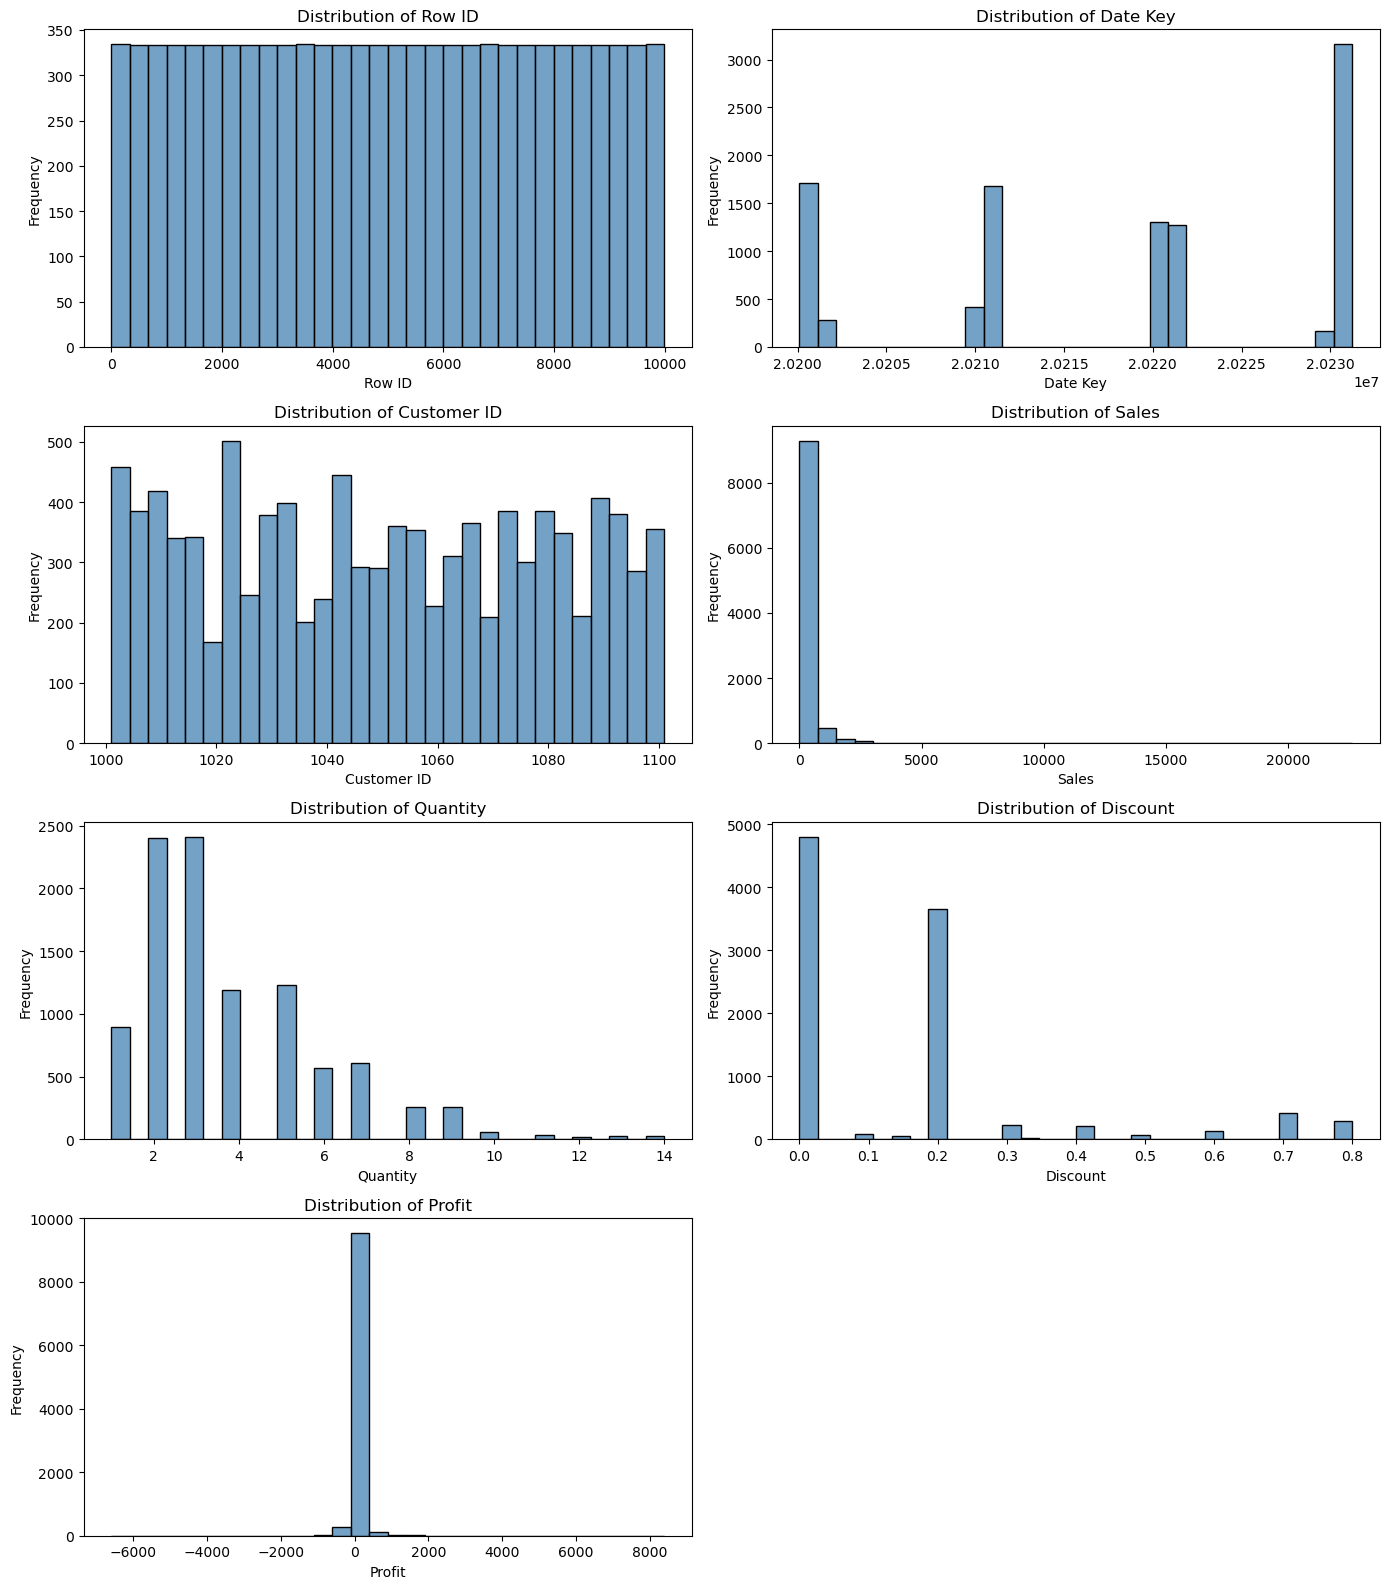

In [9]:
# Identify real numeric columns from the dataset
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Ajustar número de subplots basado en cantidad de columnas numéricas
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols

# Fig
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

# Plot
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], bins=30, color='steelblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(len(numeric_cols), len(axes)):
    axes[j].set_visible(False)
    
plt.tight_layout()
plt.show()

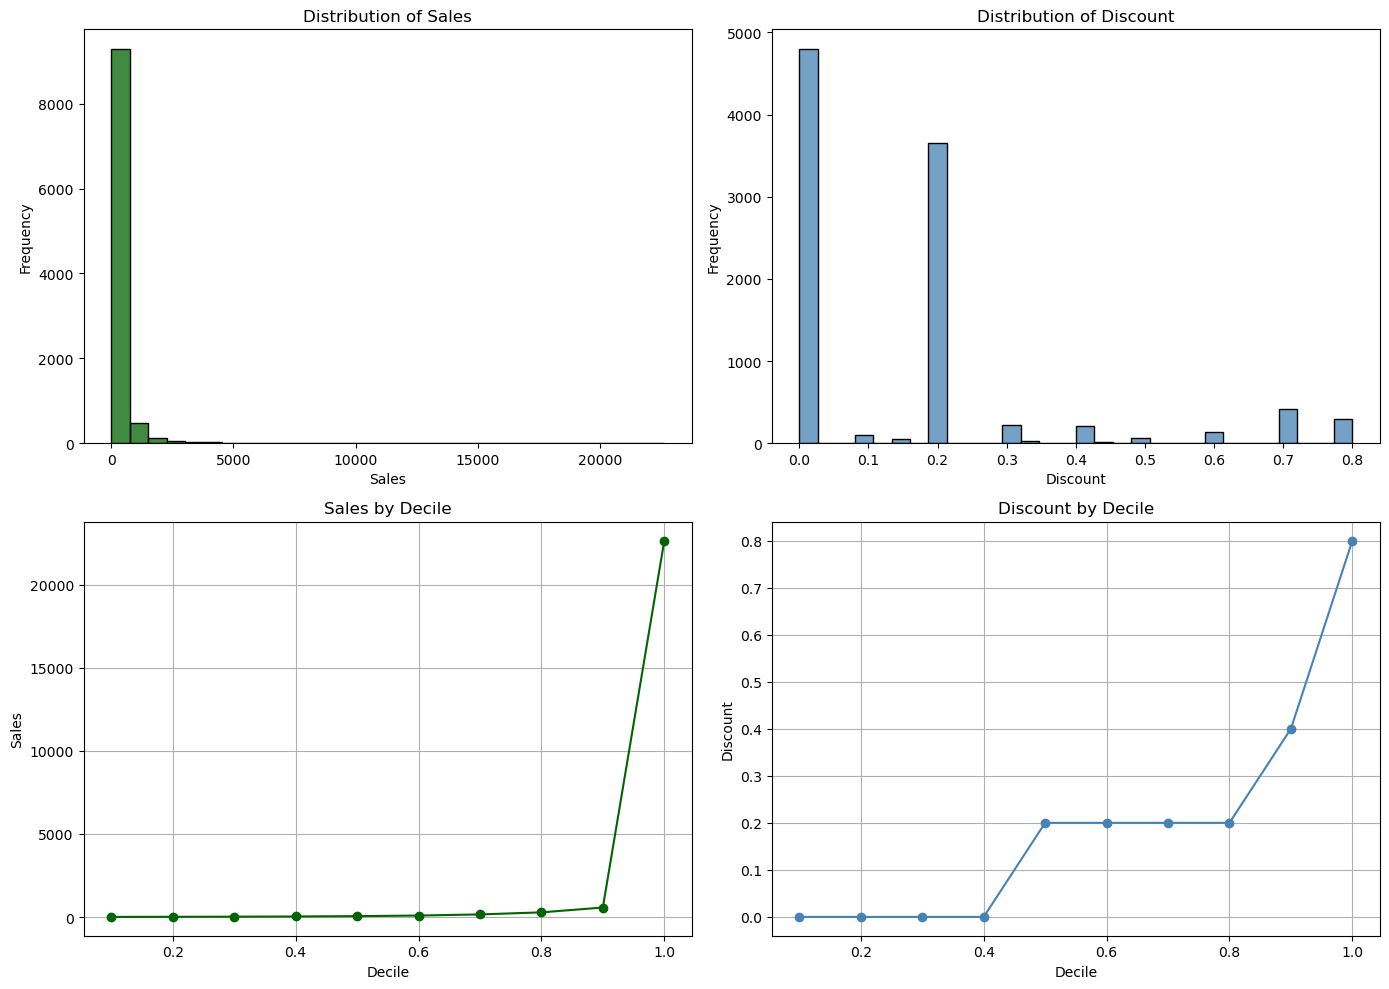

In [10]:
################### Clean Version #####################
# Data Distribution and Feature Relevance
# Columns and quantiles
num_cols = ['Sales', 'Discount']
q = np.arange(0.1, 1.1, 0.1)
dec = {col: df[col].quantile(q) for col in num_cols}

# Fig format
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['darkgreen', 'steelblue']

# Histograms
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[0, i], bins=30, color=colors[i])
    axes[0, i].set(title=f'Distribution of {col}', xlabel=col, ylabel='Frequency')

# Decile plots
for i, col in enumerate(num_cols):
    axes[1, i].plot(q, dec[col], marker='o', color=colors[i])
    axes[1, i].set(title=f'{col} by Decile', xlabel='Decile', ylabel=col)
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()

In [11]:
# Asegurar que 'Sales' sea numérico
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

# Filtrar y contar ventas superiores a 5000
high_sales_count = (df['Sales'] > 5000).sum()

print(f"Sales greater than $5,000: {high_sales_count}")


Sales greater than $5,000: 19


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


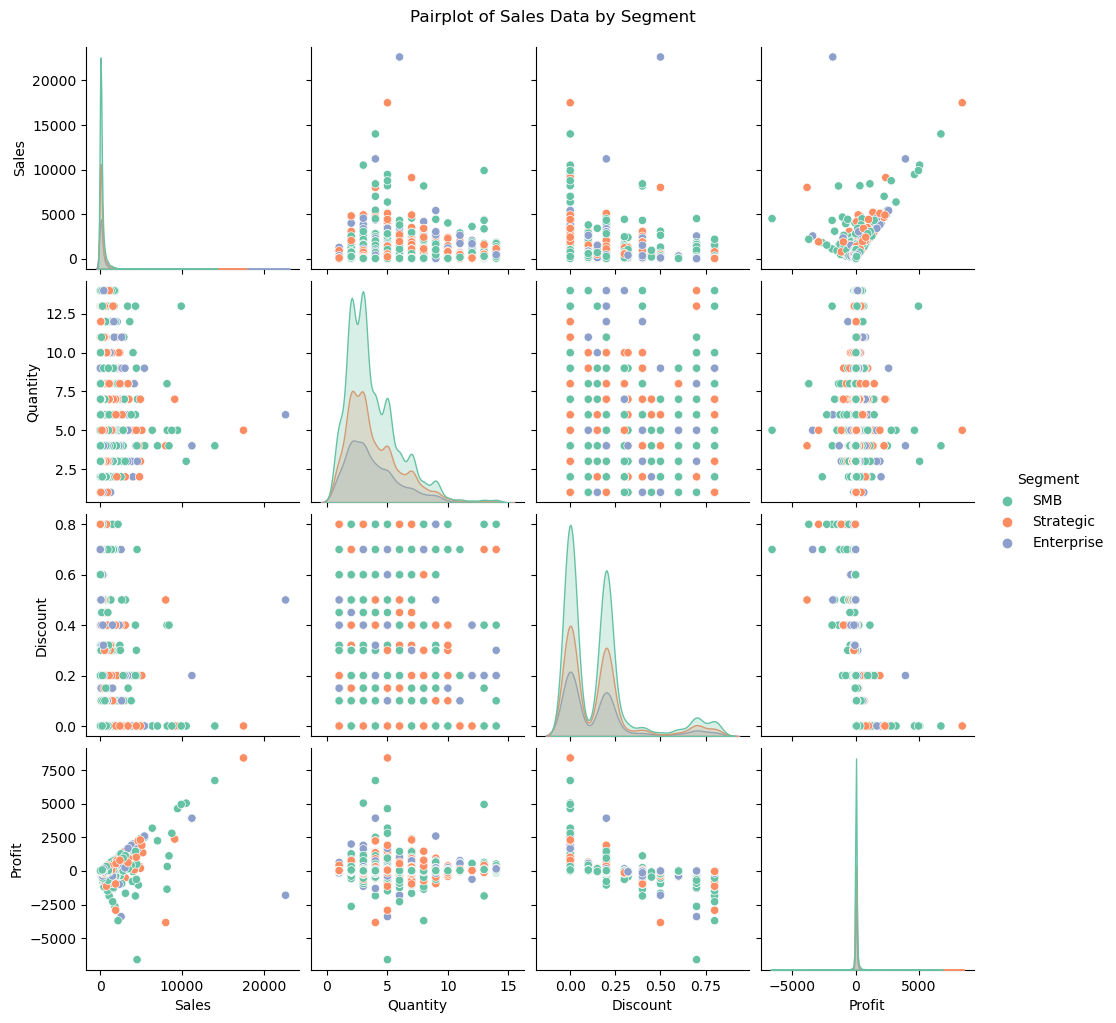

In [12]:
cols = ['Sales', 'Quantity', 'Discount', 'Profit']
df_sample = df[cols + ['Segment']].dropna()

# Pairplot
sns.pairplot(df_sample, hue='Segment', diag_kind='kde', palette='Set2')
plt.suptitle('Pairplot of Sales Data by Segment', y=1.02)
plt.show()


In [13]:
# Calculate min, max and average sales by segment
segment_stats = df.groupby('Segment')['Sales'].agg(['min', 'mean', 'max']).round(2).reset_index()

display(segment_stats)

# DF Visualization
segment_stats_melted = segment_stats.melt(id_vars='Segment', var_name='Metric', value_name='Sales')

,Segment,min,mean,max
0,Enterprise,0.99,240.97,22638.48
1,SMB,0.44,223.73,13999.96
2,Strategic,0.56,233.82,17499.95


In [14]:
#Acumulative percentage per category
col = 'Segment' 
summary = ( df[col].value_counts(normalize=False).rename_axis('Class').reset_index(name='Count'))
summary['Percentage'] = (summary['Count'] / summary['Count'].sum() * 100).round(2)
summary['Cumulative %'] = summary['Percentage'].cumsum().round(2)
summary

,Class,Count,Percentage,Cumulative %
0,SMB,5191,51.94,51.94
1,Strategic,3020,30.22,82.16
2,Enterprise,1783,17.84,100.00


In [15]:
#Acumulative percentage per category
col = 'Industry'  
summary = ( df[col].value_counts(normalize=False).rename_axis('Class').reset_index(name='Count'))
summary['Percentage'] = (summary['Count'] / summary['Count'].sum() * 100).round(2)
summary['Cumulative %'] = summary['Percentage'].cumsum().round(2)
summary

,Class,Count,Percentage,Cumulative %
0,Finance,2127,21.28,21.28
1,Energy,1316,13.17,34.45
2,Tech,1236,12.37,46.82
3,Manufacturing,1222,12.23,59.05
4,Healthcare,1049,10.50,69.55
5,Consumer Products,1021,10.22,79.77
6,Retail,972,9.73,89.50
7,Communications,593,5.93,95.43
8,Transportation,351,3.51,98.94
9,Misc,107,1.07,100.01


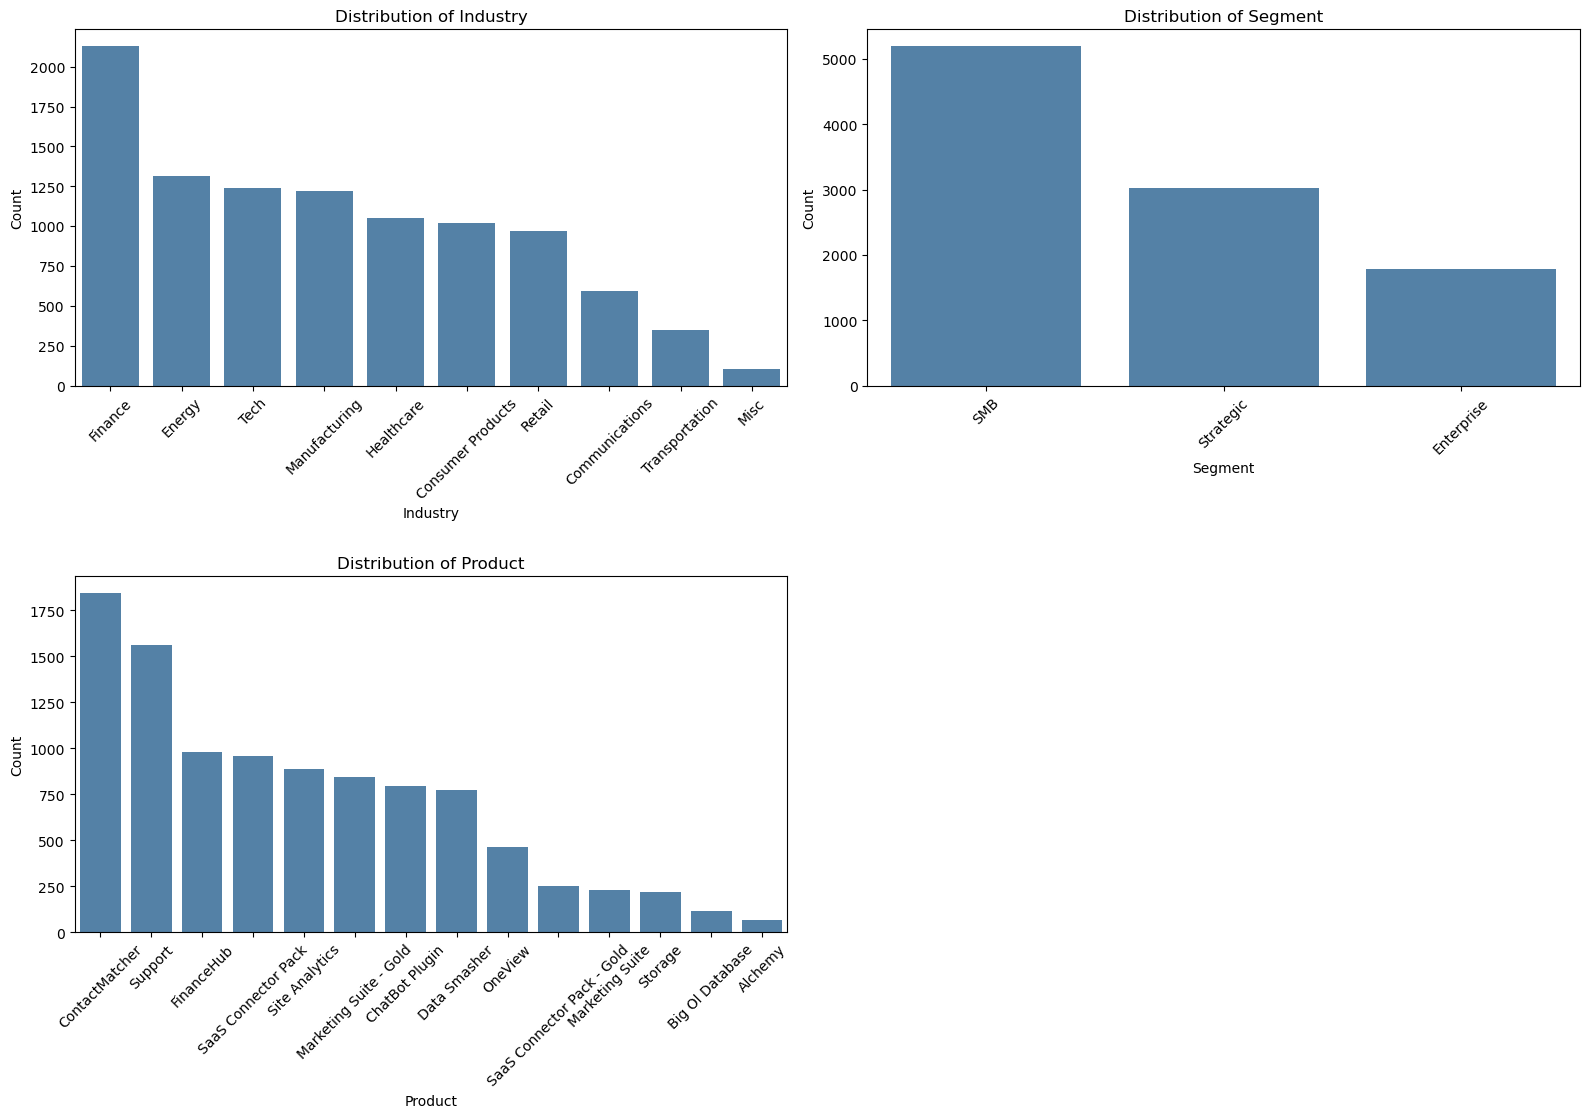

In [16]:
################### Clean Version #####################
###### Frequency distribution charts by relevant category fields

# Lista de columnas categóricas relevantes
relevant_cat_col = ['Industry', 'Segment', 'Product']

# Fig
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 15))  # 3 filas x 2 columnas
axes = axes.flatten() 

# Graficar cada columna categórica
for i, col in enumerate(relevant_cat_col):
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order, color='steelblue', ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Ocultar el subplot vacío
if len(relevant_cat_col) < len(axes):
    for j in range(len(relevant_cat_col), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

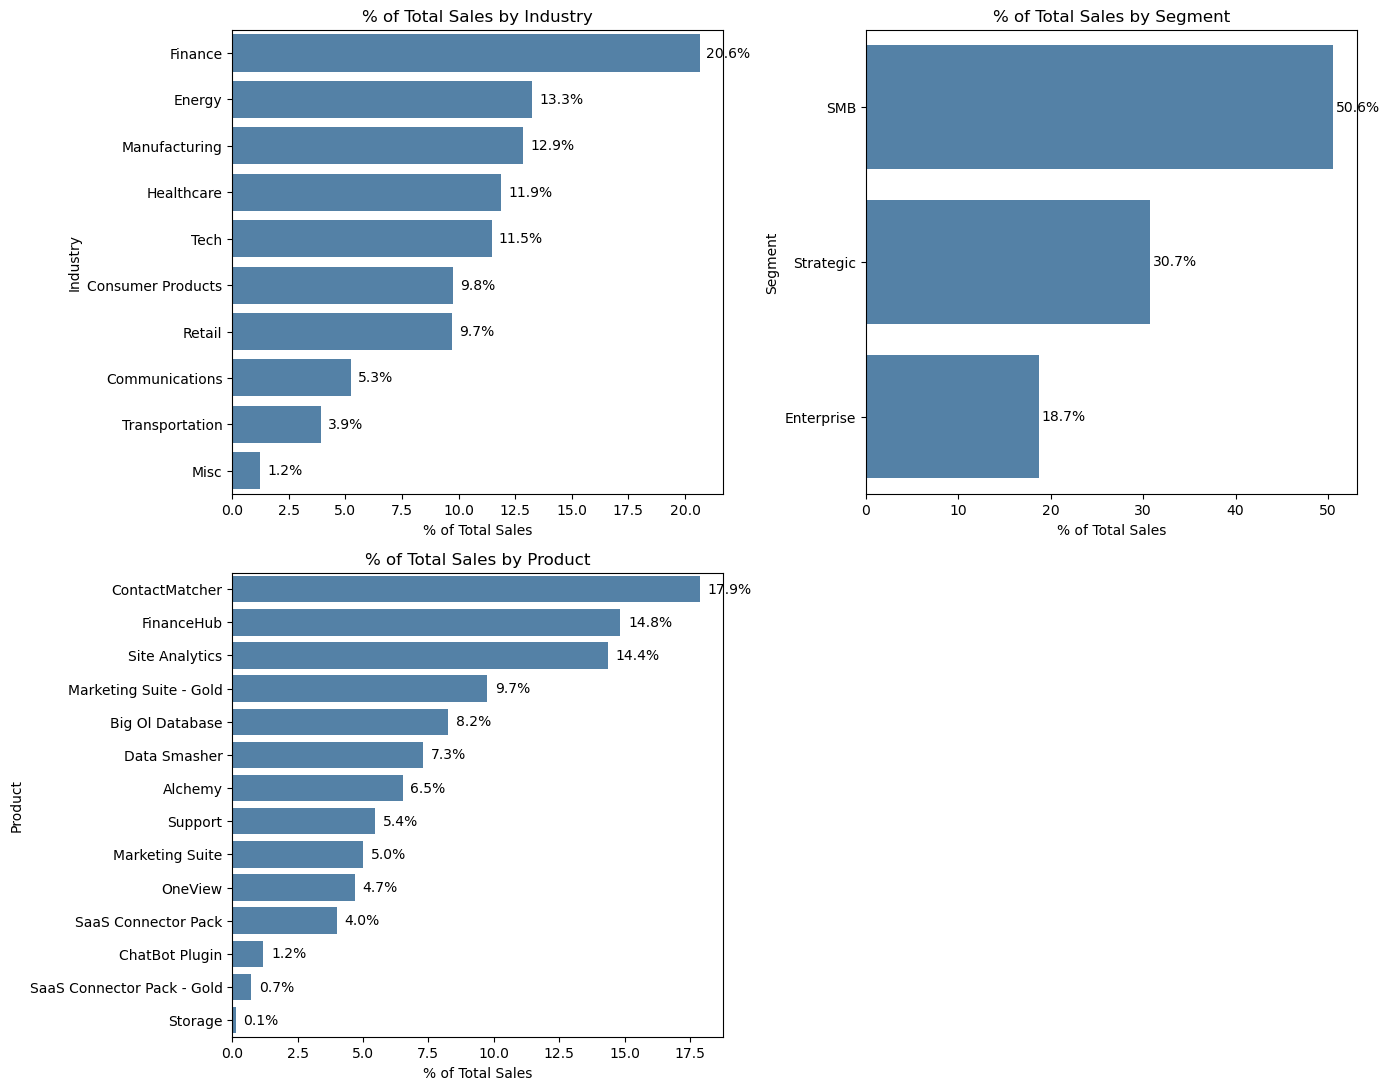

In [17]:
################## Sales Contribution (%) by relevant category variable ##################
cat_cols = relevant_cat_col
# Define relevant categorical columns
total_sales = df['Sales'].sum()

# Fig format
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 16))
axes = axes.flatten()

# Histograms
for i, col in enumerate(cat_cols):
    pct = df.groupby(col)['Sales'].sum().sort_values(ascending=False) / total_sales * 100
    sns.barplot(x=pct.values, y=pct.index, ax=axes[i], color='steelblue')
    axes[i].set_title(f'% of Total Sales by {col}')
    axes[i].set_xlabel('% of Total Sales')
    axes[i].set_ylabel(col)
    for j, val in enumerate(pct.values):
        axes[i].text(val + 0.3, j, f'{val:.1f}%', va='center', fontsize=10)

# Hide unused axes
for ax in axes[len(cat_cols):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

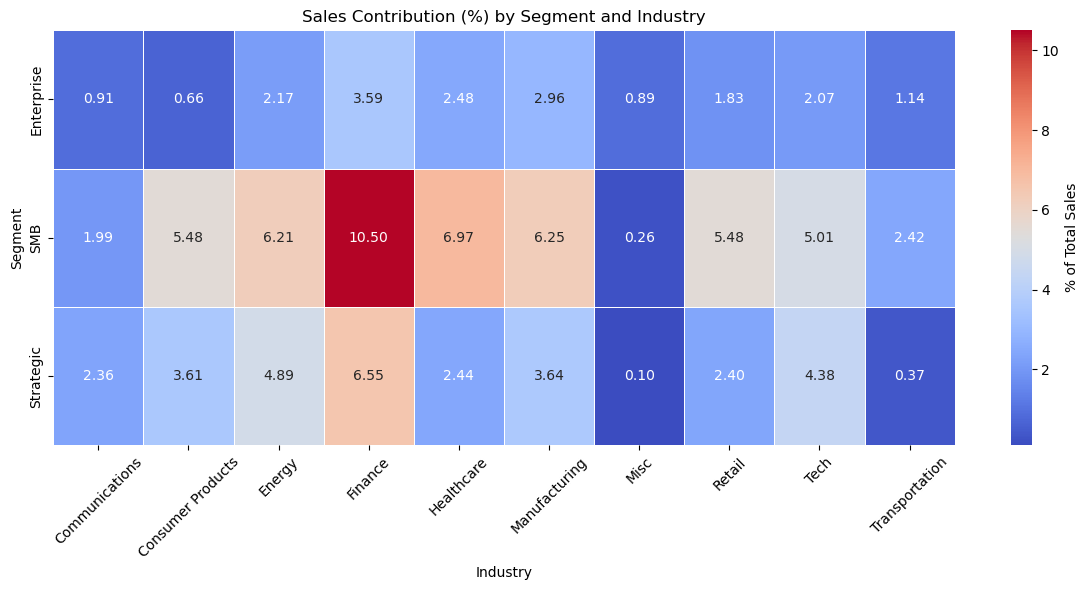

In [18]:
############ Clean Version #######################
# Sales Contribution (%) by Segment and Industry
# Pivot table: total sales no discount by Segment and Industry
sales_pivot = df.pivot_table(index='Segment',columns='Industry', values='Sales',aggfunc='sum',fill_value=0)

# Convert to percentages
total_sales = sales_pivot.values.sum()
sales_pct = (sales_pivot / total_sales * 100).round(2)

# Plot heatmap with % values
plt.figure(figsize=(12, 6))
sns.heatmap(sales_pct, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5, cbar_kws={'label': '% of Total Sales'})
plt.title('Sales Contribution (%) by Segment and Industry')
plt.xlabel('Industry')
plt.ylabel('Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
############ Clean Version #######################
# Group by Segment and Industry, sum sales
grouped1 = (
    df.groupby(['Segment', 'Industry'])['Sales']
    .sum()
    .reset_index()
    .sort_values('Sales', ascending=False)
)

# Calculate percentage and cumulative percentage
total_sales = grouped1['Sales'].sum()
grouped1['% of Total'] = grouped1['Sales'] / total_sales * 100
grouped1['Cumulative %'] = grouped1['% of Total'].cumsum()

# Filter combinations that make up more than 80% cumulatively
top_80 = grouped1[grouped1['Cumulative %'] <= 80]

# Display the result
top_80.head(5).style.hide(axis=0)

Segment,Industry,Sales,% of Total,Cumulative %
SMB,Finance,241120.291400,10.496265,10.496265
SMB,Healthcare,160185.326200,6.973066,17.469331
Strategic,Finance,150572.652400,6.554614,24.023945
SMB,Manufacturing,143552.513400,6.249019,30.272964
SMB,Energy,142548.299600,6.205304,36.478268


In [20]:
############ TOP 5 sales by Industry #######################
# Group by Segment, Industry, and Product to sum Sales
grouped2 = (
    df.groupby(['Industry'])['Sales']
    .sum()
    .reset_index()
    .sort_values('Sales', ascending=False)
)
# Calculate percentage and cumulative percentage
total_sales2 = grouped2['Sales'].sum()
grouped2['% of Total'] = grouped2['Sales'] / total_sales * 100
grouped2['Cumulative %'] = grouped2['% of Total'].cumsum()

grouped2.head(5).style.hide(axis=0)

Industry,Sales,% of Total,Cumulative %
Finance,474150.484400,20.640358,20.640358
Energy,304644.140900,13.261537,33.901895
Manufacturing,295192.381200,12.850090,46.751985
Healthcare,273183.288200,11.892007,58.643992
Tech,263169.027700,11.456074,70.100066


In [21]:
############ TOP 5 sales by Product #######################
# Group by Segment, Industry, and Product to sum Sales
grouped3 = (
    df.groupby(['Product'])['Sales']
    .sum()
    .reset_index()
    .sort_values('Sales', ascending=False)
)
# Calculate percentage and cumulative percentage
total_sales3 = grouped3['Sales'].sum()
grouped3['% of Total'] = grouped3['Sales'] / total_sales * 100
grouped3['Cumulative %'] = grouped3['% of Total'].cumsum()

grouped3.head(5).style.hide(axis=0)

Product,Sales,% of Total,Cumulative %
ContactMatcher,410378.265000,17.864274,17.864274
FinanceHub,340935.415000,14.841341,32.705615
Site Analytics,330007.054000,14.365616,47.071231
Marketing Suite - Gold,223843.608000,9.744190,56.815421
Big Ol Database,189238.631000,8.237792,65.053213


## Time Series

In [22]:
# Date: min and max values
df['Order Date'] = pd.to_datetime(df['Order Date']).dt.strftime("%Y-%m-%d")
print('Order Date:')
print('Min:', df['Order Date'].min())
print('Max:', df['Order Date'].max())

## Hay que crear columna de categoría mes

Order Date:
Min: 2020-01-04
Max: 2023-12-31


In [23]:
# Datetime format
df['Order Date'] = pd.to_datetime(df['Order Date']) # Otherwise it is not possible to work with the time series.

C:\Users\pcist\AppData\Local\Temp\ipykernel_2652\184831429.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


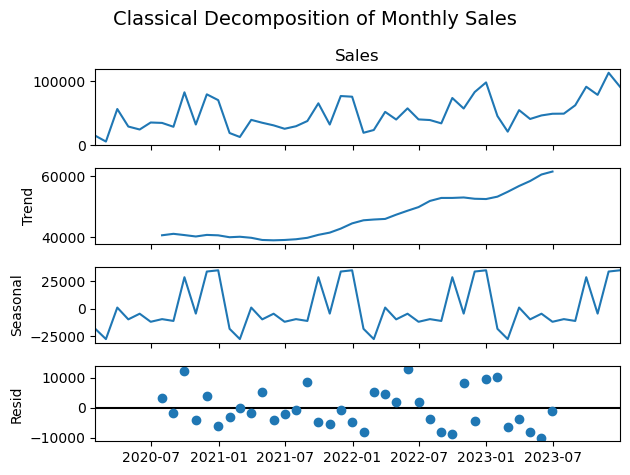

In [24]:
# Time Series resample and ploting to see sta
df_ts = df[['Order Date', 'Sales']]
df_ts.set_index('Order Date', inplace=True)
df_ts.index = pd.to_datetime(df_ts.index)
df_ts_monthly = df_ts.resample('M').sum()

# Classical decomposition (assuming yearly seasonality ~12 month)
decomp = seasonal_decompose(df_ts_monthly['Sales'], model='additive', period=12)

# Plot
decomp.plot()
plt.suptitle('Classical Decomposition of Monthly Sales', fontsize=14)
plt.tight_layout()
plt.show()


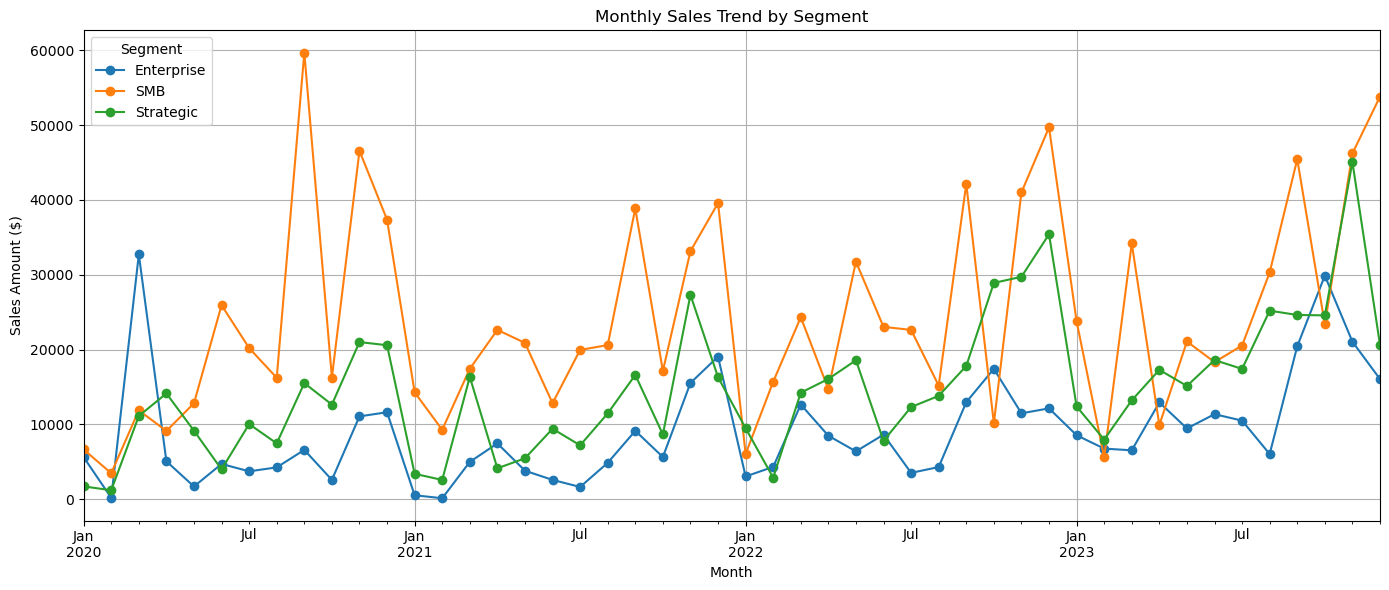

In [25]:
############ Segment Time Series #######################
# Time Series resample by month and segment (sales)
monthly_segment_sales = (df.groupby([pd.Grouper(key='Order Date', freq='M'), 'Segment'])['Sales'].sum().reset_index())
pivot_seg = monthly_segment_sales.pivot(index='Order Date', columns='Segment', values='Sales') # Pivot for plotting

# Plot
pivot_seg.plot(figsize=(14, 6), marker='o')
plt.title('Monthly Sales Trend by Segment')
plt.xlabel('Month')
plt.ylabel('Sales Amount ($)')
plt.grid(True)
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

# IV. Data Preparation

In this phase, the dataset was cleaned and transformed to prepare it for machine learning modeling. The goal was to enable the prediction of which product a customer is most likely to purchase, based on their segment, industry, and the time of year.

In [26]:
# Creating a copy of the original DF
df_c = df.copy()

In [27]:
# Calculate sale value without discount
df_c['Regular Sale'] = np.where(df['Discount'] < 1.0, df['Sales'] / (1 - df['Discount']), df['Sales'])

In [28]:
# Format datetime
df_c['Order Date'] = pd.to_datetime(df['Order Date']) # Otherwise it is not possible to work with the time series.

In [29]:
# Filter to retain only the bottom 90% of sales (remove outliers)
df_c = df_c[df_c['Sales'] <= df_c['Sales'].quantile(0.90)]

#### Drop columns

In [30]:
# Drop columns not useful or problematic for modeling
df_c.drop(columns=['Row ID', 'Order ID', 'Date Key', 'Contact Name', 'Customer', 'Customer ID', 'License'], inplace=True)
df_c.drop(columns=['City', 'Country', 'Region','Subregion'], inplace=True)
df_c.drop(columns=['Quantity', 'Discount', 'Profit'], inplace=True)
df_c.drop(columns=['Product', 'Industry', 'Sales'], inplace=True)  # Columns replaced below

#### Variable Recategorization  

In [31]:
# Reclassify Product into 4 new categories
df_c['Product Category'] = df['Product']
df_c['Product Category'].replace(['ContactMatcher', 'FinanceHub'], 'Client Intelligence', inplace=True)
df_c['Product Category'].replace(['Site Analytics', 'Data Smasher', 
                                  'Alchemy', 'Big Ol Database', 'Storage'], 'Data & Analytics', inplace=True)
df_c['Product Category'].replace(['Marketing Suite', 'Marketing Suite - Gold', 
                                  'Support'], 'Marketing & Engagement', inplace=True)
df_c['Product Category'].replace(['SaaS Connector Pack', 'SaaS Connector Pack - Gold', 
                                  'ChatBot Plugin', 'OneView'], 'Data Integration', inplace=True)

In [32]:
# Reclassify Industry into 4 new categories
df_c['Industry Category'] = df['Industry']
df_c['Industry Category'].replace(['Finance', 'Energy', 'Tech', 'Manufacturing'], 'Core Economic', inplace=True)
df_c['Industry Category'].replace(['Healthcare', 'Consumer Products'], 'Health & Consumer', inplace=True)
df_c['Industry Category'].replace(['Retail', 'Communications'], 'Retail & Comms', inplace=True)
df_c['Industry Category'].replace(['Transportation', 'Misc'], 'Other', inplace=True)

#### Refeaturing  

In [33]:
# Extract time-related features
df_c['Month'] = df_c['Order Date'].dt.month
df_c['Quarter'] = df_c['Order Date'].dt.quarter

df_c.drop(columns=['Order Date'], inplace=True)

#### Preparing for modeling

In [34]:
############ LabelEncoder #######################
df_label = df_c.copy()

obj_cols = df_label.select_dtypes(include='object').columns
le = LabelEncoder()
for col in obj_cols:
    df_label[col] = le.fit_transform(df_label[col])

In [35]:
# Spliting features and target
X = df_label.drop(columns=['Product Category'])  # Target: Product Category
y = df_label['Product Category']

In [36]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# V. Modeling

In this phase, different machine learning models were trained to predict the product category most likely to be purchased by a customer, based on variables such as industry, segment, and seasonality (month and quarter).

In [37]:
####### Model and Evaluate formula
def evaluate_model_optimized(name, model, param_grid, X_train, X_test, y_train, y_test):
    print(f"\n Tuning model: {name}")
    
    # Pipeline for each model
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    # Paramgrid search
    grid = GridSearchCV(pipe, {'model__' + k: v for k, v in param_grid.items()}, 
                        scoring='accuracy', cv=5, n_jobs=-1, verbose=0)
    
    # Fit and preds
    start_time = time.time() #timestamp
    grid.fit(X_train, y_train) 
    elapsed = time.time() - start_time #timestamp
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # Scoring
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Best parameters: {grid.best_params_}")
    print(f"Training Time: {elapsed:.2f} seconds")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix plot
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    disp.ax_.set_title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

In [38]:
# Param grids with odd-numbered intervals
param_grids = {
            "KNN": {
                "n_neighbors": list(range(1, 31, 2)),
                "weights": ['uniform', 'distance']
            },
            "Decision Tree": {
                "max_depth": list(range(1, 31, 2)),
                "min_samples_split": [2, 5, 10]
            },
            "Random Forest": {
                "n_estimators": list(range(51, 81, 2)),
                "max_depth": list(range(1, 31, 2))
            },
            "XGBoost": {
                "n_estimators": list(range(51, 81, 2)),
                "max_depth": list(range(1, 31, 2))
            }
        }



 Tuning model: KNN
Best parameters: {'model__n_neighbors': 27, 'model__weights': 'distance'}
Training Time: 18.50 seconds
Accuracy: 0.2957
F1 Score (weighted): 0.2957
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.28      0.29       485
           1       0.32      0.28      0.30       342
           2       0.30      0.32      0.31       481
           3       0.28      0.30      0.29       491

    accuracy                           0.30      1799
   macro avg       0.30      0.29      0.30      1799
weighted avg       0.30      0.30      0.30      1799



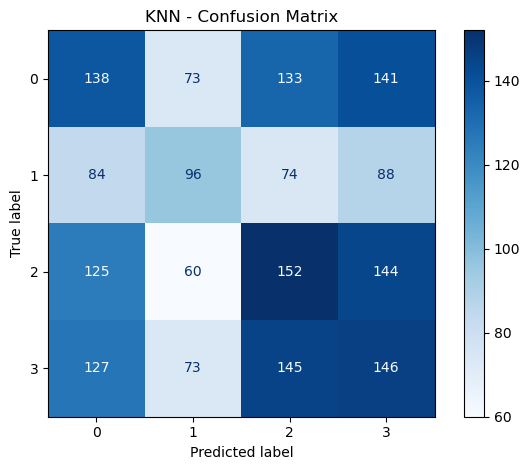


 Tuning model: Decision Tree
Best parameters: {'model__max_depth': 25, 'model__min_samples_split': 5}
Training Time: 2.13 seconds
Accuracy: 0.4842
F1 Score (weighted): 0.4836
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.54      0.50       485
           1       0.49      0.52      0.50       342
           2       0.45      0.44      0.44       481
           3       0.53      0.45      0.49       491

    accuracy                           0.48      1799
   macro avg       0.49      0.49      0.49      1799
weighted avg       0.49      0.48      0.48      1799



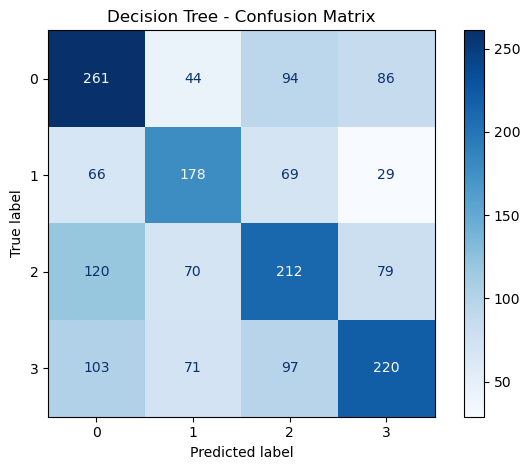


 Tuning model: Random Forest
Best parameters: {'model__max_depth': 9, 'model__n_estimators': 53}
Training Time: 60.69 seconds
Accuracy: 0.3274
F1 Score (weighted): 0.3242
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.27      0.29       485
           1       0.35      0.26      0.30       342
           2       0.33      0.34      0.34       481
           3       0.32      0.42      0.36       491

    accuracy                           0.33      1799
   macro avg       0.33      0.32      0.32      1799
weighted avg       0.33      0.33      0.32      1799



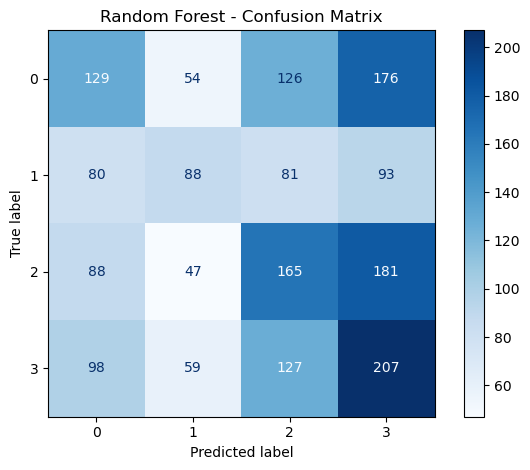


 Tuning model: XGBoost


C:\Users\pcist\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [12:59:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'model__max_depth': 3, 'model__n_estimators': 73}
Training Time: 72.99 seconds
Accuracy: 0.3658
F1 Score (weighted): 0.3655
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.33      0.34       485
           1       0.42      0.32      0.37       342
           2       0.34      0.43      0.38       481
           3       0.40      0.37      0.38       491

    accuracy                           0.37      1799
   macro avg       0.37      0.36      0.37      1799
weighted avg       0.37      0.37      0.37      1799



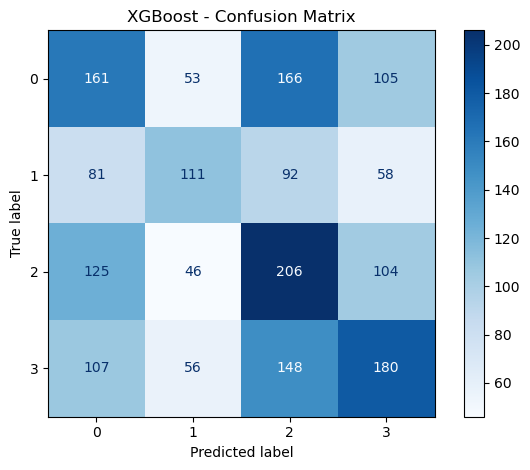

In [39]:
# Models dictionary
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Run evaluation
for name, model in models.items():
    evaluate_model_optimized(name, model, param_grids[name], X_train, X_test, y_train, y_test)

The Decision Tree was selected as the most suitable model given its alignment with the business goal: actionable and understandable insights that help improve targeted marketing strategies.

# VI. Model Improvement

The best model was the decision tree, so we will work on creating a performance improvement process.

In [40]:
# Base Pipeline for Decision Tree
pipe_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

In [41]:
# Robust cross-validation
scores_acc = cross_val_score(pipe_tree, X_train, y_train, cv=5, scoring='accuracy')
scores_f1  = cross_val_score(pipe_tree, X_train, y_train, cv=5, scoring='f1_weighted')
print(f"CV Accuracy: {scores_acc.mean():.3f} ± {scores_acc.std():.3f}")
print(f"CV F1 (wtd):  {scores_f1.mean():.3f} ± {scores_f1.std():.3f}")

CV Accuracy: 0.453 ± 0.011
CV F1 (wtd):  0.453 ± 0.011


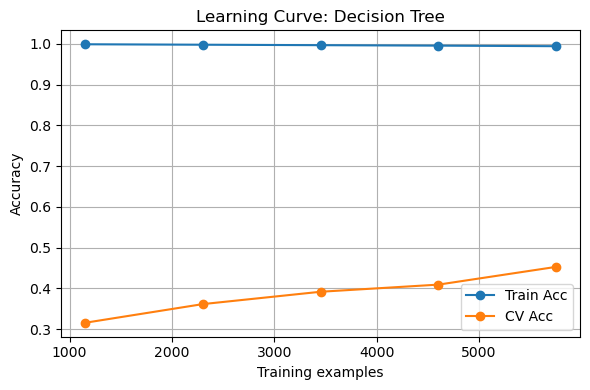

In [42]:
# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
                                                    pipe_tree, X_train, y_train, cv=5,
                                                    train_sizes=np.linspace(0.2, 1.0, 5),
                                                    scoring='accuracy'
                                                    )
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores.mean(1), 'o-', label='Train Acc')
plt.plot(train_sizes, val_scores.mean(1),   'o-', label='CV Acc')
plt.title("Learning Curve: Decision Tree")
plt.xlabel("Training examples"), plt.ylabel("Accuracy")
plt.legend(), plt.grid(True), plt.tight_layout()
plt.show()

In [43]:
# GridSearch for max_depth and min_samples_split
param_grid = {
    'clf__max_depth': [5,10,15,20,25], 
    'clf__min_samples_split': [2,5,10]
}
grid = GridSearchCV(pipe_tree, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)
best_tree = grid.best_estimator_
print("Best params:", grid.best_params_)

Best params: {'clf__max_depth': 25, 'clf__min_samples_split': 5}


              precision    recall  f1-score   support

           0       0.47      0.54      0.50       485
           1       0.49      0.52      0.50       342
           2       0.45      0.44      0.44       481
           3       0.53      0.45      0.49       491

    accuracy                           0.48      1799
   macro avg       0.49      0.49      0.49      1799
weighted avg       0.49      0.48      0.48      1799



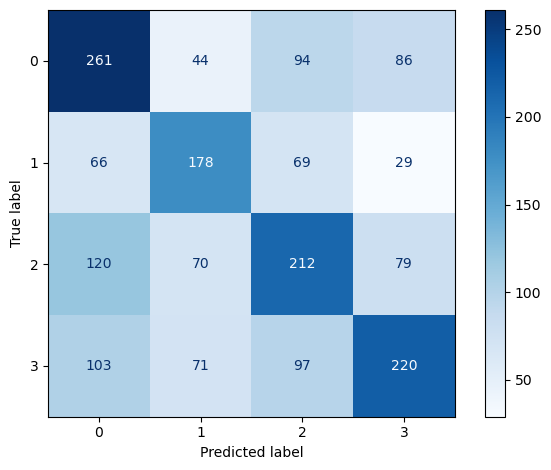

(None, None)

In [44]:
# Evaluate
y_pred = best_tree.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.tight_layout(), plt.show()

In [45]:
# Recall by class
report = classification_report(y_test, y_pred, output_dict=True)
recall = pd.DataFrame(report).loc['recall'][:4]
print("\nPer-class Recall:")
print(recall)


Per-class Recall:
0    0.538144
1    0.520468
2    0.440748
3    0.448065
Name: recall, dtype: float64


In [46]:
# Rule extraction (first 500 characters)
rules = export_text(best_tree.named_steps['clf'], feature_names=list(X.columns))
print("\nExtracted Rules:\n", rules[:500], "…")


Extracted Rules:
 |--- Regular Sale <= -0.21
|   |--- Regular Sale <= -0.66
|   |   |--- Regular Sale <= -0.70
|   |   |   |--- Regular Sale <= -0.73
|   |   |   |   |--- Industry Category <= 1.56
|   |   |   |   |   |--- Regular Sale <= -0.73
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Regular Sale >  -0.73
|   |   |   |   |   |   |--- Segment <= -0.92
|   |   |   |   |   |   |   |--- Quarter <= 0.59
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Quarter >  0.59 …
